# Implikationen unterschiedlicher Risikomanagement-Strategien auf das Wert-/Risikoprofil einer Gesamtposition
© Thomas Robert Holy 2019
<br>
Version 1.1
<br><br>
Visit me on GitHub: https://github.com/trh0ly
## Grundlegende Einstellungen:
Zunächst müssen die notwendigen Pakete (auch Module) importiert werden, damit auf diese zugegriffen werden kann. 

In [1]:
import pandas as pd # Programmbibliothek die Hilfsmittel für die Verwaltung von Daten und deren Analyse anbietet
import scipy.stats as stats # SciPy ist ein Python-basiertes Ökosystem für Open-Source-Software für Mathematik, Naturwissenschaften und Ingenieurwissenschaften
from scipy.stats import rankdata, norm  
from scipy import array, linalg, dot
import random # Dieses modul wird verwendet um Zufallszahlen zu ziehen
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import math # Dieses Modul wird verwendet um Skalardaten zu berechnen, z. B. trigonometrische Berechnungen.
import operator # Programmbibliothek, welche die Ausgaben übersichtlicher gestaltet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
import matplotlib.patches as mpatches
import datetime as dt # Das datetime-Modul stellt Klassen bereit, mit denen Datums- und Uhrzeitangaben auf einfache und komplexe Weise bearbeitet werden können
import random # Dieses Modul implementiert Pseudozufallszahlengeneratoren für verschiedene Verteilungen.
from riskmeasure_module import risk_measure as rm # Dieses "Modul" vereinfacht die Berechnung der Risikomaße
from IPython.core.display import display, HTML

Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 350)
SCREEN_WIDTH = 120
centered = operator.methodcaller('center', SCREEN_WIDTH)
plt.rcParams["figure.figsize"] = 15,15

### Funktionen definieren
Als nächstes werden Funktionen definiert. Diese vereinfachen das Plotten oder führen Berechnungen durch.

In [4]:
#-------------------------------------------------------------------------
# Funktion zum plotten der historische Simulation
def hist_sim(values, bins):
    H, X1 = np.histogram(values, bins, density=True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H) * dx 
    plt.plot(X1[1:], F1) 
    
#-------------------------------------------------------------------------
# Funktion zum plotten der Varianz-Kovarianz-Methode
def var_co_var_sim(mini_values_PF, maxi_values_PF, bins, mu, std):    
    array = np.array(np.arange(0.0001, 1, 0.0001))
    var_covar_results = stats.norm.ppf(array, mu, std)
    var_covar_range = np.linspace(mini_values_PF, maxi_values_PF, bins)
    plt.plot(var_covar_range, stats.norm.cdf(var_covar_range, mu, std)) 
    return var_covar_results

#-------------------------------------------------------------------------
# Funktion für restliche Einstellungen für die Grafik
def easy_plot():
    plt.xlabel('Rendite') 
    plt.ylabel('Wahrscheinlichkeit') 
    blue_patch = mpatches.Patch(color='blue', label='Historische Simulation') 
    orange_patch = mpatches.Patch(color='orange', label='Varianz-Kovarianzmethode') 
    plt.legend(handles=[orange_patch, blue_patch]) 
    plt.title('Verteilungsfunktion: Historische Simulation versus Varianz-Kovarianz-Methode')
    plt.grid() 
    plt.axhline(0, color='black') 
    plt.axvline(0, color='black') 
    plt.show() 
    
#-------------------------------------------------------------------------
# Funktion zu Berechnung der Risikomaße und Ausgabe
RM_list = [] 
def risk(values, alpha=0.1, gamma=0.5):   
    #---------------------------
    # Nutzung der objektorientierten Programmierung 
    x = rm(values, alpha, gamma)
    VaR = float(x.VaR())
    CVaR = float(x.CVaR())
    expected_value = float(x.expected_value)
    Power = float(x.Power())
    tmp_list = [VaR, CVaR, Power, expected_value]

    #---------------------------
    # Ausgabe Value at Risk
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der VaR beträgt: ' + str(VaR) + '.') + '| ')

    #---------------------------
    # Ausgabe Conditional Value at Risk
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der CVaR beträgt: ' + str(CVaR) + '.') + '| ')

    #---------------------------
    # Ausgabe Power-Spektrales Risikomaß
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Power-Spektrales Risikomaß bei der Monte-Carlo-Simulation:') + '| ')
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der Erwartungswert beträgt: ' + str(expected_value) + '.') + '| ')
    print('|' + centered('Das Risiko beträgt: ' + str(Power) + '.') + '| ')
    print('#' + SCREEN_WIDTH * '-' + '#')
    
    return tmp_list

## Datensätze einlesen und manipulieren:
Nun werden Datensätze eingelesen und manipuliert.
Die Datensätze werden manuell definiert und anschließend zum Array "dateinamen" hinzufügt.
Standardmäßig werden fünf Datensätze (BAS.DE, ..., VOW3.DE) definiert und im Array "dateinamen" gespeichert.
<br>
Anschließend wird aus jedem eingelesen Datensatz der Aktienkurs zum jeweiligen Tag extrahiert werden. 
Dieser Schritt wird automatisiert, indem zunächst die leere Liste "kurse" anlegt wird und anschließend von jedem sich in der Liste "dateinamen" befindenden Eintrag die jeweiligen Spalten "Date" und "Adj Close" eingelesen werden.
Dabei werden die verschiedenen im Datensatz vorhanden Spalten mit jedem Komma separiert und Punkte werden als Zeichen für die Dezimaltrennung interpretiert. Anschließend werden die so extrahierten Daten zum Array "kurse" hinzugefügt.
<br>
Danach wird das Modul `datetime` genutzt, um die Datumsspalte des jeweiligen Datensatzes bearbeitbar zu machen.
Zudem wird dem Programm mitgeteilt, dass die Einträge der Spalte "Adj Close" numerisch sind und mit ihnen gerechnet werden kann. Kommt es dabei zu Fehlern werden die entsprechende Werte als NaN-Werte behandelt.
<br><br>
Hinweis: An dieser Stelle können ebenfalls andere Datensätze eingelesen werden, sofern die entsprechenden Datensätze im Home-Verzeichnis hochgeladen wurden.

In [5]:
##########################################################################
#-------------------------------------------------------------------------
# Datensätze defininieren und in Array abspeichern
trading_days = 253 # Anzahl der Handelstage in einem Jahr

datensatz1 = 'BAS.DE'
datensatz2 = 'FME.DE'
datensatz3 = 'NSU.DE'
datensatz4 = 'SIE.DE'
datensatz5 = 'VOW3.DE'

dateinamen = [datensatz1, datensatz2, datensatz3, datensatz4, datensatz5]

#-------------------------------------------------------------------------
##########################################################################
#-------------------------------------------------------------------------
# Datensätze aus dem Array einlesen und "rechenbar" machen
kurse = []
for eintrag in dateinamen:
    kurs = pd.read_csv(str(eintrag) + '.csv',
                decimal='.',
                usecols=['Date','Adj Close'])
    kurse.append(kurs) 

for eintrag in kurse:
    eintrag['Date'] = pd.to_datetime(eintrag['Date']) 
    eintrag['Adj Close'] = pd.to_numeric(eintrag['Adj Close'], errors='coerce') 

Nun werden zwei verschiedene DataFrames erzeugt, wobei "kurschart_0" die Basis für das Sharpe-Portfolio und "kurschart_1" die Basis für die Naive Diversifikation darstellt.
Beide beinhalten die täglichen aus den eingelesenen Aktienkursen berechneten Renditen, wobei für "kurschart_1" direkt die Portfolio-Rendite mittels Naiver Diversifikation ermittelt wird.
Beide DataFrames sind auf die Handelstage eines Jahres beschränkt.

In [6]:
#-------------------------------------------------------------------------
# DataFrame mit Aktienkursen, Renditen und Portfolio-Rendite bei naiver Diversifikation erstellen
kurschart_0 = pd.DataFrame()
kurschart_1 = pd.DataFrame()

zaehler = 0
for eintrag in kurse:
    x = dateinamen[zaehler]
    kurschart_0['Aktienkurs ' + str(x)] = eintrag['Adj Close']
    kurschart_1['Aktienkurs ' + str(x)] = eintrag['Adj Close']    
    zaehler += 1

kurschart_0 = kurschart_0[:(trading_days - 1)]
kurschart_0 = kurschart_0.pct_change()
kurschart_1 = kurschart_1[:(trading_days - 1)]
kurschart_1 = kurschart_1.pct_change()

#-------------------------------------------------------------------------
# Naive Diversifikation 
kurschart_1['PF-Rendite (naiv)'] = (kurschart_1.sum(axis = 1, skipna = True) / len(dateinamen))
kurschart_1

,Aktienkurs BAS.DE,Aktienkurs FME.DE,Aktienkurs NSU.DE,Aktienkurs SIE.DE,Aktienkurs VOW3.DE,PF-Rendite (naiv)
0,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.005680,0.020879,NaN,0.007092,0.000560,0.006842
2,0.005525,0.005232,-0.001344,0.001718,0.007698,0.003766
3,-0.003785,0.006624,-0.013459,0.000172,-0.008889,-0.003867
4,0.018262,0.009636,0.006821,0.004286,0.009529,0.009707
...,...,...,...,...,...,...
247,-0.001914,0.005092,0.015306,-0.029373,-0.000259,-0.002230
248,0.000480,-0.008162,-0.007538,-0.009371,0.001294,-0.004660
249,-0.033232,-0.054484,0.012658,-0.001774,-0.005426,-0.016452
250,-0.006445,0.016507,-0.002500,-0.005133,-0.010133,-0.001541


## Bestimmung des optimalen Sharpe-Portfolios mittels Monte-Carlo-Simulation
In diesem Abschnitt werden zunächst die jährlichen Renditen und Kovarianzen der einzelnen Assets bestimmt.
Anschließend wird auf Basis dieser Informationen eine Monte-Carlo-Siumulation durchgeführt durch welche das optimale Sharpe-Portfolio bestimmt wird.
Hierfür werden n Zufallszahlen gezogen (n = Anzahl der Assets im Portfolio), welche anschließend so nomiert werden, dass sie in Summe Eins ergeben aber die Relationen untereinander erhalten bleiben.
Im Anschluss wird die jeweilige jährliche Renditen der Assets mit dem jeweiligen zuvor ermittelten Gewicht multipliziert, sodass sich eine Portfolio-Rendite ergibt.
Gleichermaßen wird die dazugehörige Volatilität bestimmt, sodass daraufhin der Sharpe-Ratio ermittelt werden kann.
Die so berechneten Größen werden jeweils in einer Liste gespeichert und in den DataFrame "PF_DataFrame" überführt, aus welchem sowohl das optimale Sharpe- als auch das Minimum-Varianz-Portfolio bestimmt wird.
Zum Schluss wird eine Grafik generiert, welche den effizienten Rand darstellt.
<br>
Der Sharpe-Ratio berechnet sich wie folgt: $S := \frac{\overline{D}}{\sigma_D}$
<br>
<br>
wobei $\overline{D} := \frac{1}{T} \sum_{t=1}^{T} D_t$ (durchschnittliche Überrendite der Geldanlage im Vergleich zur risikolosen Anlage)
<br>
<br>
und $\sigma_D := \sqrt{\frac{\sum_{t=1}^T \left(D_t - \overline{D}\right)^2}{T - 1}}$ (Die Volatilität im Form der empirischen Standardabweichung)
<br><br>
Hinweis: Dieser Programmteil entstand in Anlehngung an "Efficient Frontier & Portfolio Optimization with Python" von Bernard Brenyah (https://github.com/PyDataBlog/Python-for-Data-Science/blob/master/Tutorials/Efficient%20Frontier%20with%20Sharpe%20Ratio.py) **

#------------------------------------------------------------------------------------------------------------------------#
|                                Überblick über die Ergebnisse der Monte-Carlo-Simulation                                | 
   PF_Return  PF_Volatility  PF_Sharpe_Ratio  BAS.DE Weight  FME.DE Weight  NSU.DE Weight  SIE.DE Weight  VOW3.DE Weight
0  -0.018325       0.036117        -0.507366       0.146483       0.066249       0.275420       0.354102        0.157746
1  -0.140963       0.049857        -2.827356       0.502562       0.363693       0.048486       0.044744        0.040514
2  -0.048842       0.041919        -1.165162       0.359759       0.196281       0.197846       0.004666        0.241449
3  -0.116171       0.052702        -2.204311       0.358956       0.451812       0.005678       0.096030        0.087524
4   0.022074       0.034638         0.637283       0.052414       0.172160       0.431078       0.184573        0.159775
#--------------------------

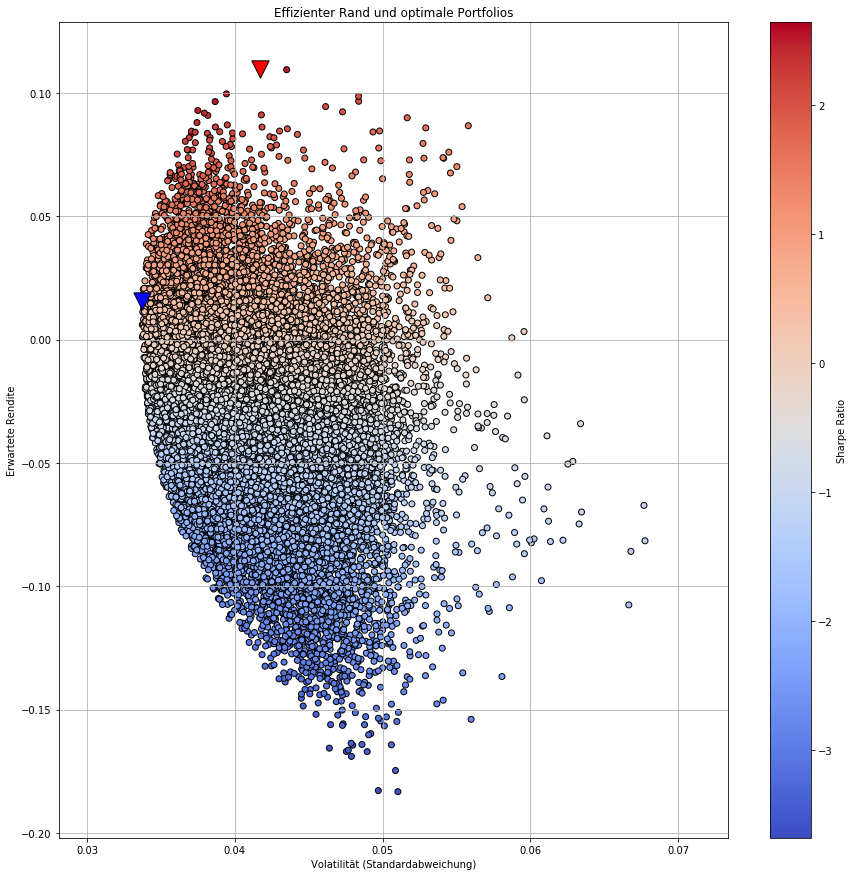

#------------------------------------------------------------------------------------------------------------------------#
Minimum-Varianz-Portfolio: 
                    24156
PF_Return        0.015833
PF_Volatility    0.033734
PF_Sharpe_Ratio  0.469354
BAS.DE Weight    0.033343
FME.DE Weight    0.080677
NSU.DE Weight    0.456062
SIE.DE Weight    0.337945
VOW3.DE Weight   0.091974
#------------------------------------------------------------------------------------------------------------------------#
Optimales Sharpe-Portfolio: 
                     4388
PF_Return        0.109957
PF_Volatility    0.041685
PF_Sharpe_Ratio  2.637827
BAS.DE Weight    0.013288
FME.DE Weight    0.002541
NSU.DE Weight    0.435564
SIE.DE Weight    0.015922
VOW3.DE Weight   0.532685
#------------------------------------------------------------------------------------------------------------------------#


In [7]:
returns_annual = kurschart_0.mean() * trading_days
cov_daily = kurschart_0.cov()
cov_annual = cov_daily * math.sqrt(trading_days)

#-------------------------------------------------------------------------
# Listen für die Speicherung von Berechnungsergebnissen anlegen
PF_return_list, PF_volatility_list = [], []
sharpe_ratio_list, asset_weights_list = [], []

#-------------------------------------------------------------------------
# Ausführung Monte-Carlo-Simulation mit n Durchläufen zur Bestimmung von Portfolio-Kombinationen
n = 25000
num_of_assets = len(dateinamen)
for i in range(0,n):
    random_weights = np.random.random(num_of_assets)
    PF_weights = random_weights / np.sum(random_weights)
    
    PF_returns = np.dot(PF_weights, returns_annual)
    PF_volatility = np.sqrt(np.dot(PF_weights.T, np.dot(cov_annual, PF_weights)))
    sharpe_ratio = PF_returns / PF_volatility

    asset_weights_list.append(PF_weights)
    PF_return_list.append(PF_returns)
    PF_volatility_list.append(PF_volatility)
    sharpe_ratio_list.append(sharpe_ratio)

#-------------------------------------------------------------------------
# Erstellung DataFrame mit Erwartungswerten, Standardabweichungen und Assetgewichten für jedes simulierte Portfolio
# Des Weiteren Ermittlung desjenigen simulierten Portfolios mit dem höchsten Sharpe-Ratio und des Minimum-Varianz-Portfolios
PF_DataFrame = pd.DataFrame({'PF_Return': PF_return_list, 'PF_Volatility': PF_volatility_list, 'PF_Sharpe_Ratio': sharpe_ratio_list})
for counter, dateiname in enumerate(dateinamen):
    PF_DataFrame[str(dateiname) + ' Weight'] = [weight[counter] for weight in asset_weights_list]
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Überblick über die Ergebnisse der Monte-Carlo-Simulation') + '| ')
print(PF_DataFrame.head())
print('#' + SCREEN_WIDTH * '-' + '#')

min_volatility = PF_DataFrame['PF_Volatility'].min()
max_sharpe_ratio = PF_DataFrame['PF_Sharpe_Ratio'].max()
Sharpe_PF = PF_DataFrame.loc[PF_DataFrame['PF_Sharpe_Ratio'] == max_sharpe_ratio]
Min_variance_PF = PF_DataFrame.loc[PF_DataFrame['PF_Volatility'] == min_volatility]

#-------------------------------------------------------------------------
# Berechnungsergebnisse mit einer Heatmap plotten
plt.scatter(PF_volatility_list, PF_return_list, c = sharpe_ratio_list, marker='o', cmap='coolwarm', edgecolors='black')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(x = Sharpe_PF['PF_Volatility'], y = Sharpe_PF['PF_Return'], color='red', marker='v', edgecolors='black', s=300)
plt.scatter(x = Min_variance_PF['PF_Volatility'], y = Min_variance_PF['PF_Return'], color='blue', edgecolors='black', marker='v', s=300)
plt.grid()
plt.ylabel('Erwartete Rendite')
plt.title('Effizienter Rand und optimale Portfolios')
plt.xlabel('Volatilität (Standardabweichung)')
plt.show()

#-------------------------------------------------------------------------
# Ausgabe von Informationen zum optimalen Sharpe-Portfolio und zum Minimum-Varianz-Portfolio
print('#' + SCREEN_WIDTH * '-' + '#')
print('Minimum-Varianz-Portfolio: \n' + str(Min_variance_PF.T))
print('#' + SCREEN_WIDTH * '-' + '#')
print('Optimales Sharpe-Portfolio: \n' + str(Sharpe_PF.T))
print('#' + SCREEN_WIDTH * '-' + '#')

## Optimales Sharpe-Portfolio und Datenbereinigung
In diesem Schritt werden die durch die Monte-Carlo-Simulation ermittelten optimalen Gewichte des Sharpe-Portfolios auf den DataFrame "kurschart_0" angewendet, sodass im Anschluss die Portfolio-Rendite errechnet werden kann.
Danach werden die Portfolio-Renditen in einer Liste gespeichert und bereinigt.

In [8]:
#-------------------------------------------------------------------------
# Optimale Portfolio-Gewichte des Sharpe-Portfolios extrahieren und auf Aktienrenditen anwenden
Sharpe_PF = Sharpe_PF.values.tolist()
Sharpe_PF = Sharpe_PF[0][3::]
kurschart_0 = kurschart_0.multiply(Sharpe_PF, axis = 1)
kurschart_0['PF-Rendite (sharpe)'] = kurschart_0.sum(axis = 1, skipna = True)

#-------------------------------------------------------------------------
# Datenbereinigung
sharpe_values_PF = kurschart_0['PF-Rendite (sharpe)'].values.tolist()
sharpe_values_PF = np.array(sharpe_values_PF)
sharpe_values_PF = sharpe_values_PF[np.logical_not(np.isnan(sharpe_values_PF))]

#----------------------------------
# Naiv diversifiziertes Portfolio extrahieren
naiv_values_PF = kurschart_1['PF-Rendite (naiv)'].values.tolist()
naiv_values_PF = np.array(naiv_values_PF)
naiv_values_PF = naiv_values_PF[np.logical_not(np.isnan(naiv_values_PF))]

## Auswertung des Sharpe-Portfolios
### Funktionen Definieren und Verteilungsfunktionen plotten
In diesem Abschnitt werden zunächst Mittelwert und Standardabweichung des Sharpe-Portfolios berechnet und ausgegeben. 
Anschließend werden Funktionen definiert, welche das Plotten der Verteilungsfunktionen für die historische Simulation und die Varianz-Kovarianz-Methode und die Ermittlung der Risikomaße auf Basis des jeweiligen Simulationsverfahrens vereinfachen.

##########################################################################################################################
|                                                Optimales PF nach Sharpe                                                | 
##########################################################################################################################
#------------------------------------------------------------------------------------------------------------------------#
|                   [INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. 0.00043224761478120204.                   | 
#------------------------------------------------------------------------------------------------------------------------#
|                      [INFO] Das Porfolio hat eine Standardabweichung i.H.v. 0.010405154938571316.                      | 
#------------------------------------------------------------------------------------------------------------------------#


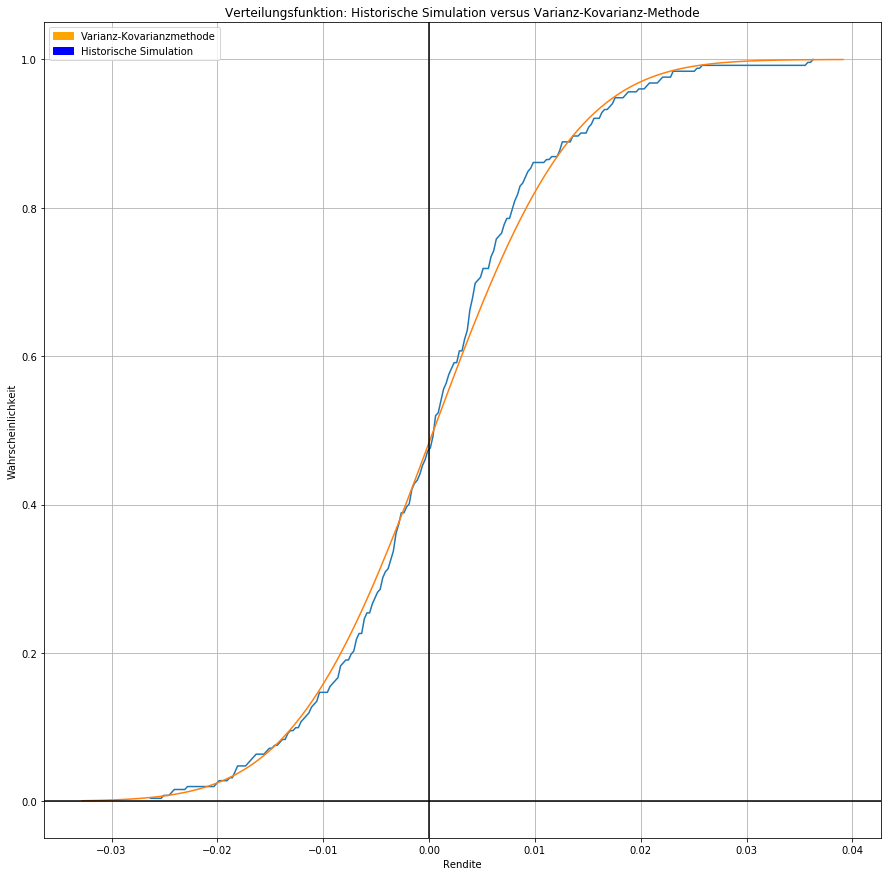

In [9]:
#-------------------------------------------------------------------------
# Berechnung Standardabweichung, Erwartungswert und Ausgabe
print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Optimales PF nach Sharpe') + '| ')
print((SCREEN_WIDTH + 2) * '#')
mu_sharpe_PF = np.mean(sharpe_values_PF)
std_sharpe_PF = np.std(sharpe_values_PF)
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. ' + str(mu_sharpe_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Das Porfolio hat eine Standardabweichung i.H.v. ' + str(std_sharpe_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

mini_values_PF = min(min(naiv_values_PF), min(sharpe_values_PF))
maxi_values_PF = max(max(naiv_values_PF), max(sharpe_values_PF)) 
bins = len(naiv_values_PF)

#-------------------------------------------------------------------------
# Funktionsaufruf: Zum plotten der historische Simulation    
hist_sim(sharpe_values_PF, bins)

#-------------------------------------------------------------------------
# Funktionsaufruf: Zum plotten der Varianz-Kovarianz-Methode    
var_covar_results_sharpe = var_co_var_sim(mini_values_PF, maxi_values_PF, bins, mu_sharpe_PF, std_sharpe_PF)

#-------------------------------------------------------------------------
# Funktionsaufruf: Für restliche Einstellungen für die Grafik
easy_plot() 

### Risikomaße schätzen - Parameterfestlegung und Aufruf der Funktionen

In [10]:
##########################################################################
#-------------------------------------------------------------------------

alpha = 0.1
gamma = 0.5

#-------------------------------------------------------------------------
##########################################################################

#-------------------------------------------------------------------------
# Funktionsaufruf zur Berechnung der Risikomaße und Ausgabe: Historische Simulation
print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Sharpe: Risikomessung - Historische Simulation') + '| ')
print((SCREEN_WIDTH + 2) * '#')
sub_rm_list = risk(sharpe_values_PF, alpha, gamma)
RM_list.append(sub_rm_list)

#-------------------------------------------------------------------------
# Funktionsaufruf zur Berechnung der Risikomaße und Ausgabe: Varianz-Kovarianz-Methode
print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Sharpe: Risikomessung - Varianz-Kovarianz-Methode') + '| ')
print((SCREEN_WIDTH + 2) * '#')
sub_rm_list = risk(var_covar_results_sharpe, alpha, gamma)
RM_list.append(sub_rm_list)

##########################################################################################################################
|                                     Sharpe: Risikomessung - Historische Simulation                                     | 
##########################################################################################################################
#------------------------------------------------------------------------------------------------------------------------#
|                                         Der VaR beträgt: 0.012661148748008813.                                         | 
#------------------------------------------------------------------------------------------------------------------------#
|                                        Der CVaR beträgt: 0.017982446874413954.                                         | 
#------------------------------------------------------------------------------------------------------------------------#
|            

## Auswertung des naiv diversifizierten Portfolios
Da die Funktionen zum Plotten der Verteilungsfunktionen und zur Risikomessung im vorherigen Schritt bereits definiert wurden, müssen diese hier nur noch mit den entsprechenden Daten der naiven Diversifikation aufgerufen werden.

##########################################################################################################################
|                                                 Naive Diversifikation                                                  | 
##########################################################################################################################
#------------------------------------------------------------------------------------------------------------------------#
|                  [INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. -0.00012575966763054915.                   | 
#------------------------------------------------------------------------------------------------------------------------#
|                   [INFO] Das Porfolio hat somit eine Standardabweichung i.H.v. 0.009822461574843634.                   | 
#------------------------------------------------------------------------------------------------------------------------#


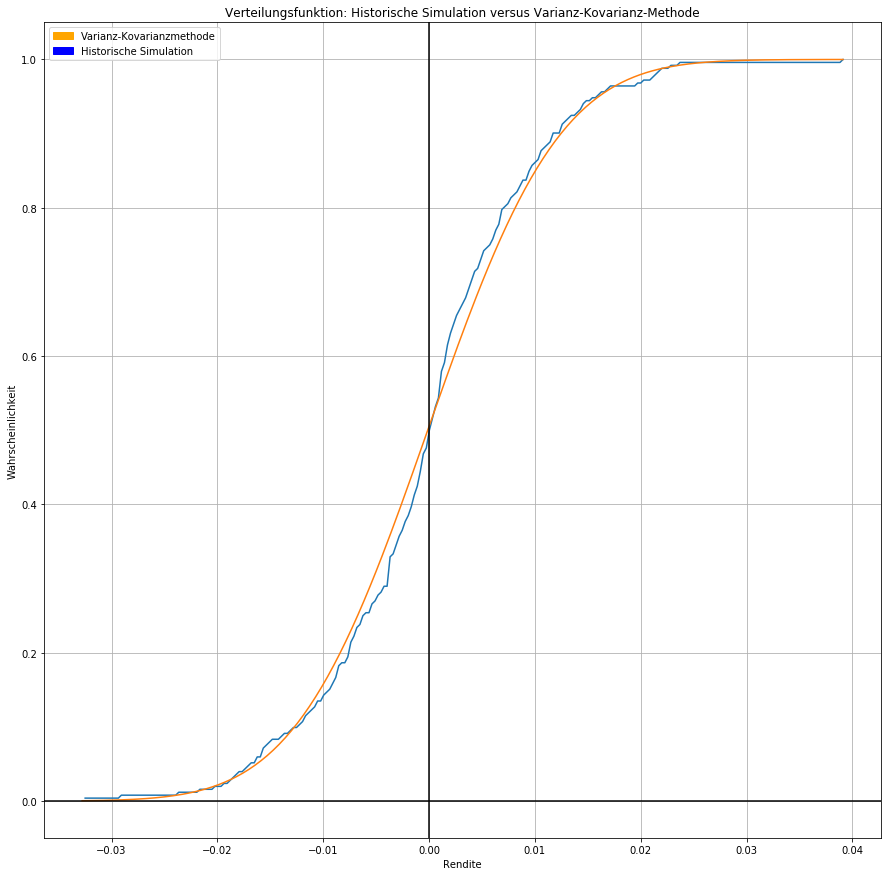

##########################################################################################################################
|                                      Naiv: Risikomessung - Historische Simulation                                      | 
##########################################################################################################################
#------------------------------------------------------------------------------------------------------------------------#
|                                         Der VaR beträgt: 0.013091035489033587.                                         | 
#------------------------------------------------------------------------------------------------------------------------#
|                                        Der CVaR beträgt: 0.018124431872575855.                                         | 
#------------------------------------------------------------------------------------------------------------------------#
|            

In [11]:
#-------------------------------------------------------------------------
# Berechnung Standardabweichung, Erwartungswert und Ausgabe
print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Naive Diversifikation') + '| ')
print((SCREEN_WIDTH + 2) * '#')
mu_naiv_PF = np.mean(naiv_values_PF)
std_naiv_PF = np.std(naiv_values_PF)
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. ' + str(mu_naiv_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Das Porfolio hat somit eine Standardabweichung i.H.v. ' + str(std_naiv_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

#-------------------------------------------------------------------------
# Funktionsaufruf: Historische Simulation - Plot
hist_sim(naiv_values_PF, bins)

#-------------------------------------------------------------------------
# Funktionsaufruf: Varianz-Kovarianz-Methode - Plot
var_covar_results_hist = var_co_var_sim(mini_values_PF, maxi_values_PF, bins, mu_naiv_PF, std_naiv_PF)

#-------------------------------------------------------------------------
# Funktionsaufruf: Restliche Einstellungen für die Grafik
easy_plot() 

#-------------------------------------------------------------------------
# Funktionsaufruf zur Berechnung der Risikomaße und Ausgabe: Historische Simulation

print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Naiv: Risikomessung - Historische Simulation') + '| ')
print((SCREEN_WIDTH + 2) * '#')
sub_rm_list = risk(naiv_values_PF, alpha, gamma)
RM_list.append(sub_rm_list)

#-------------------------------------------------------------------------
# Funktionsaufruf zur Berechnung der Risikomaße und Ausgabe: Varianz-Kovarianz-Methode
print((SCREEN_WIDTH + 2) * '#')
print('|' + centered('Naiv: Risikomessung - Varianz-Kovarianz-Methode') + '| ')
print((SCREEN_WIDTH + 2) * '#')
sub_rm_list = risk(var_covar_results_hist, alpha, gamma)
RM_list.append(sub_rm_list)

## Gegenüberstellung der Verteilungsfunktionen und Risikomaße
Um die Verteilungsfunktionen und die berechneten Risikomaße besser vergleichen zu können, werden diese hier noch einmal zusammengetragen.

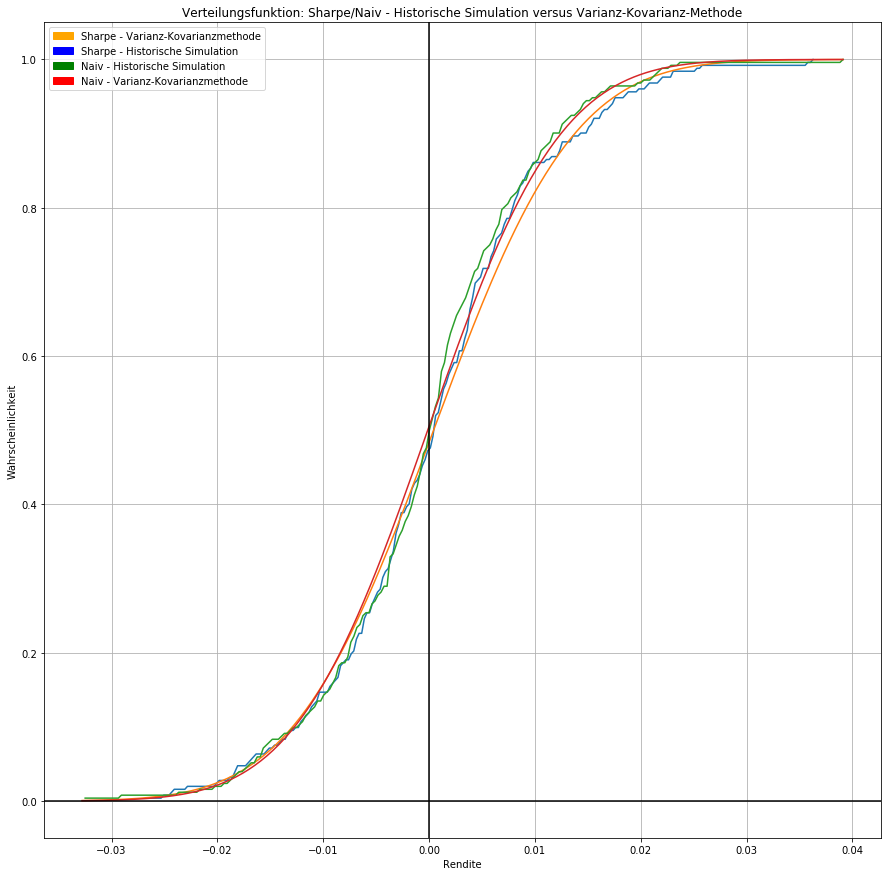

#------------------------------------------------------------------------------------------------------------------------#
|                              Sharpe Portfolio versus Naive Diversifikation: Risikomessung                              | 
#------------------------------------------------------------------------------------------------------------------------#
              Sharpe + Historisch  Naiv + Historisch  Sharpe + VarKoVar  Naiv + VarKoVar
Index                                                                                   
VaR                      0.012661           0.013091           0.012908         0.012719
CVaR                     0.017982           0.018124           0.017819         0.017355
P-SRM (Risk)            -0.006464          -0.007141          -0.006835        -0.006986
P-SRM (EW)               0.000432          -0.000126           0.000432        -0.000126
#-----------------------------------------------------------------------------------------------

In [12]:
#-------------------------------------------------------------------------
# Sharpe-Portfolio: Historische Simulation - Plot (Blau)
hist_sim(sharpe_values_PF, bins)

#-------------------------------------------------------------------------
# Sharpe-Portfolio: Varianz-Kovarianz-Methode - Plot (Orange)
_ = var_co_var_sim(mini_values_PF, maxi_values_PF, bins, mu_sharpe_PF, std_sharpe_PF)

#-------------------------------------------------------------------------
# Naive Diversifikation: Historische Simulation - Plot (Grün)
hist_sim(naiv_values_PF, bins)

#-------------------------------------------------------------------------
# Naive Diversifikation: Varianz-Kovarianz-Methode - Plot (Rot)
_ = var_co_var_sim(mini_values_PF, maxi_values_PF, bins, mu_naiv_PF, std_naiv_PF)

#-------------------------------------------------------------------------
# Restliche Einstellungen für die Grafik
plt.xlabel('Rendite') 
plt.ylabel('Wahrscheinlichkeit') 
blue_patch = mpatches.Patch(color='blue', label='Sharpe - Historische Simulation') 
orange_patch = mpatches.Patch(color='orange', label='Sharpe - Varianz-Kovarianzmethode') 
green_patch = mpatches.Patch(color='green', label='Naiv - Historische Simulation') 
red_patch = mpatches.Patch(color='red', label='Naiv - Varianz-Kovarianzmethode')     
plt.legend(handles=[orange_patch, blue_patch, green_patch, red_patch]) 
plt.title('Verteilungsfunktion: Sharpe/Naiv - Historische Simulation versus Varianz-Kovarianz-Methode')
plt.grid() 
plt.axhline(0, color='black') 
plt.axvline(0, color='black') 
plt.show() 

#-------------------------------------------------------------------------
# DataFrame Risikomessung: Übersicht
RM_DataFrame = pd.DataFrame()
RM_DataFrame['Index'] = ['VaR', 'CVaR', 'P-SRM (Risk)', 'P-SRM (EW)']
RM_DataFrame['Sharpe + Historisch'] = RM_list[0]
RM_DataFrame['Naiv + Historisch'] = RM_list[2]
RM_DataFrame['Sharpe + VarKoVar'] = RM_list[1]
RM_DataFrame['Naiv + VarKoVar'] = RM_list[3]
RM_DataFrame = RM_DataFrame.set_index('Index')

print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Sharpe Portfolio versus Naive Diversifikation: Risikomessung') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print(RM_DataFrame)
print('#' + SCREEN_WIDTH * '-' + '#')

___

** Hinweis zur Verwendung des modizifierten Quellcodes von Bernard Brenyah zur Bestimmung des Sharpe Portfolios mittels Monte-Carlo Simulation:

MIT License

Copyright (c) 2018 Bernard Brenyah

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.